In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir("../")

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import torch

from graph_utils import GraphData, load_graph, verify_graph, degrees, grid_extent

# Overlay Mesh Graph on UK Map

In [4]:
proj = ccrs.PlateCarree()

In [5]:
def add_geo_features(ax):
    ax.add_feature(cfeature.BORDERS, linestyle=':')
      
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
def add_cities(ax, cities):
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'ro', transform=proj)
        ax.text(lon + 0.1, lat + 0.1, city, transform=proj)
        
def bounding_box(ax, box):
    lon_min, lon_max, lat_min, lat_max = box
    top_left = [lon_min, lat_max]
    top_right = [lon_max, lat_max]
    bottom_left = [lon_min, lat_min]
    bottom_right = [lon_max, lat_min]
    
    corners = [
        bottom_left,
        top_left,
        top_right,
        bottom_right,
        bottom_left,
    ]
    
    lons, lats = zip(*corners)
    
    ax.plot(
        lons, lats,
        "r-", 
        transform=proj
    )
    
def grid_points(ax, grid_xy, color="green", markersize=1):
    ax.plot(grid_xy[0], grid_xy[1], 'o', color=color, transform=proj, markersize=markersize)

def mesh_points(ax, mesh_pos, mesh_node_levels=None, filter_level=None, color="g"):
    color_map = {
        0: 'blue',
        1: 'green',
        2: 'orange',
        3: 'cyan',
        4: 'magenta',
        5: 'yellow',
        6: 'black'
    }
    if mesh_node_levels:
        for i in range(len(mesh_pos[0])):
            if filter_level and mesh_node_levels[i] != filter_level:
                continue
            node_color = color_map[mesh_node_levels[i]]
            ax.plot(mesh_pos[0][i], mesh_pos[1][i], 'o', color=node_color, transform=proj, markersize=3)
    else:
        ax.plot(mesh_pos[0], mesh_pos[1], 'o', color=color, transform=proj, markersize=3)

def m2m_edges(ax, mesh_pos, m2m_edge_set, style="g-"):        
    for edge in m2m_edge_set:
        source = mesh_pos[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            style, 
            transform=proj,
            linewidth=0.5
        )
        
def coarse2fine_edges(ax, coarse_pos, fine_pos, coarse2fine_edge_set):
    for edge in coarse2fine_edge_set:
        source = coarse_pos[:, edge[0]]
        target = fine_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=proj,
            linewidth=0.5
        )
        
def g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set, mesh_node_levels=None, filter_mesh_level=None): 
    for edge in g2m_edge_set:
        if mesh_node_levels and filter_mesh_level and mesh_node_levels[edge[1]] != filter_mesh_level:
            continue
        source = grid_xy[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "b-", 
            transform=proj,
            linewidth=0.5
        )

def m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set):        
    for edge in m2g_edge_set:
        source = mesh_pos[:, edge[0]]
        target = grid_xy[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "r-", 
            transform=proj,
            linewidth=0.5
        )
        
def border_mask(ax, grid_xy, border_mask, marker_size=1):
    border_mask = border_mask.reshape(-1)
    for i, mask in enumerate(border_mask):
        if mask:
            pattern = 'ro'
        else:
            pattern = 'go'
        ax.plot(grid_xy[0][i], grid_xy[1][i], pattern, transform=proj, markersize=marker_size)
        
        

## Load datas

In [6]:

dataset = "era5_uk_small"
graph_name = "uk_small_ico"

# dataset = "era5_uk"
# graph_name = "uk_ico"

# dataset = "era5_uk_big"
# graph_name = "uk_big_ico"

# dataset = "era5_uk_max"
# graph_name = "uk_max_ico"

dataset_coarse = "era5_uk_big_coarse"
coarse_graph_name = "uk_big_coarse_ico"

# dataset_coarse = "era5_uk_max_coarse"
# coarse_graph_name = "uk_max_coarse_ico"

In [7]:
graph = load_graph(dataset, graph_name)
coarse_graph = load_graph(dataset_coarse, coarse_graph_name)
# full_coarse_graph = load_graph(dataset_coarse, f"{coarse_graph_name}_full")

(2, 46, 40)
(2, 27, 27)


In [8]:
verify_graph(graph)

Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(1839)
Mesh nodes min, max:  tensor(0) tensor(78)
Grid Nodes unique: 1840
Mesh nodes unique: 79
Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(78)
Mesh nodes min, max:  tensor(0) tensor(1839)
Grid Nodes unique: 79
Mesh nodes unique: 1840
Grid Bounding box:
[-8.0, 1.75, 49.75, 61.0]


## Fine 2 Coarse graph edges

In [9]:
coarse2fine_edge_index = torch.load(f"./graphs/{graph_name}/big_coarse2fine_v2_edge_index.pt")
coarse2fine_edge_set = sorted(list({tuple(e) for e in coarse2fine_edge_index.T}))

## Border Mask

In [10]:
mask = np.load(f"data/{dataset}/static/border_mask.npy").astype(int)
mask.shape

(46, 40)

In [11]:
graph.grid_xy.shape

(2, 1840)

In [12]:
coarse_graph.mesh_pos.shape

torch.Size([2, 73])

In [13]:
graph.mesh_pos

tensor([[ 0.0000, -7.0464, -8.7832, -3.9284,  0.0000,  2.0821, -4.4176, -6.2244,
         -2.0821, -5.5735, -7.8201,  0.0000, -3.5366, -1.8631,  1.8631, -2.3594,
         -7.0464,  2.3594,  1.0729,  2.2121, -8.7832, -7.7259, -2.2121, -3.2158,
         -1.0729, -7.4688, -5.3497, -6.6100, -3.0324, -4.1587, -5.0456, -6.3299,
         -7.4132, -8.1170, -5.8810, -6.6690, -4.7742, -8.5494, -8.2739, -9.0301,
         -7.0464,  0.0000, -1.9665, -1.0116,  1.0116,  1.9665, -5.2965, -4.5304,
         -0.9079, -2.7219, -1.7700, -3.7222, -2.8687,  2.8687,  1.7700,  2.7219,
          0.9079, -0.9570,  0.0000,  0.9570, -6.0234,  0.8636,  2.5893, -4.3102,
         -2.5893, -0.8636, -1.1421, -3.4228, -6.0823, -4.7108, -3.6582, -5.6926,
         -7.9447, -8.4848, -9.3587,  1.1421,  0.0000,  1.2209, -1.2209],
        [58.2825, 50.4010, 57.9795, 54.3173, 50.6142, 56.2993, 58.2062, 56.1602,
         56.2993, 52.3479, 54.1273, 54.3811, 50.5606, 52.4645, 52.4645, 60.2535,
         60.0870, 60.2535, 57.2915, 

In [14]:
a = graph.mesh_pos.numpy().T
b = coarse_graph.mesh_pos.numpy().T
a = set([tuple(x) for x in a])
b = set([tuple(x) for x in b])

intersection = np.array(list(a.intersection(b))).T


In [15]:
a.intersection(b)

{(-8.78323, 57.979473),
 (-7.8201294, 54.127266),
 (-7.0464063, 50.40097),
 (-7.0464063, 60.086983),
 (-6.224352, 56.16024),
 (-5.573523, 52.34792),
 (-4.4175677, 58.206238),
 (-3.9283588, 54.317257),
 (-3.5365753, 50.560596),
 (-2.3593814, 60.253464),
 (-2.0820675, 56.299282),
 (-1.863066, 52.46453),
 (0.0, 50.614166),
 (0.0, 54.38109),
 (0.0, 58.28252),
 (1.863066, 52.46453),
 (2.0820675, 56.299282),
 (2.3593814, 60.253464)}

In [21]:
space = torch.load("/work/ec249/ec249/bet20/neural-lam-refactor/wandb/offline-run-20240614_084440-2rsx0e6t/files/mean_spatial_loss.pt")

In [22]:
space.shape

torch.Size([28, 6561])

# Plot Map

UK Settlements Bounding box:
[-8.0, 1.75, 49.75, 61.0]
UK Settlements Bounding box:
[-8.0, 1.75, 49.75, 61.0]


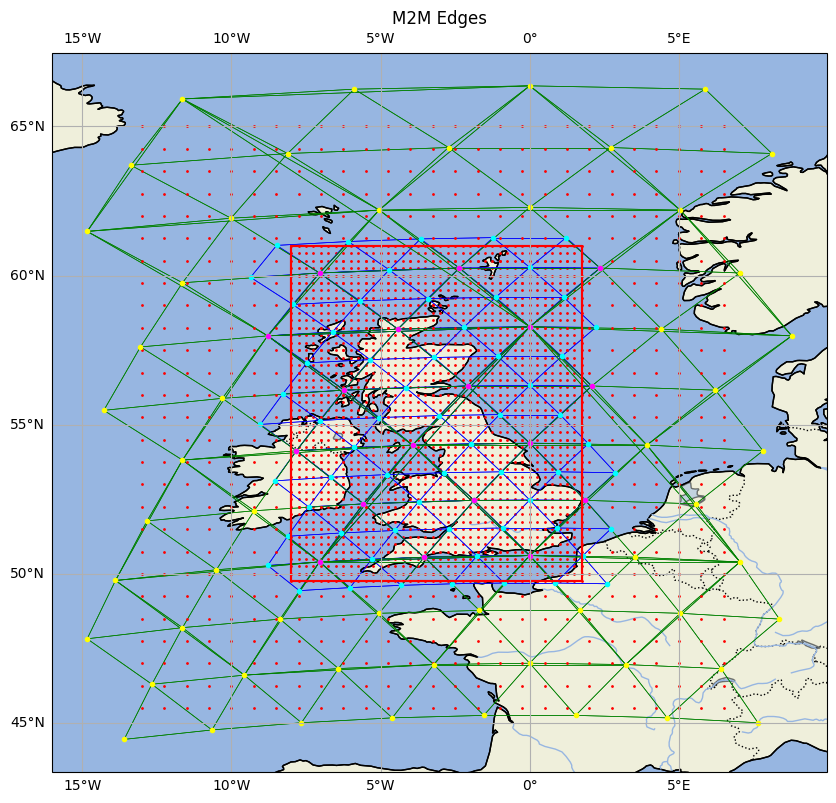

In [19]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

# Add geographical features
add_geo_features(ax)

# Add cities
# cities = {
#     'London': (-0.1276, 51.5074),
#     'Edinburgh': (-3.1883, 55.9533),
#     'Cardiff': (-3.1791, 51.4816),
#     'Belfast': (-5.9301, 54.5973)
# }
# add_cities(ax, cities)

# g2m_edges(ax, graph.grid_xy, graph.mesh_pos, graph.g2m_edge_set)
# m2m_edges(ax, graph.mesh_pos, graph.m2m_edge_set)
# m2g_edges(ax, graph.grid_xy, graph.mesh_pos, graph.m2g_edge_set)
grid_points(ax, graph.grid_xy, "red")
# border_mask(ax, graph.grid_xy, mask, marker_size=1)
# mesh_points(ax, graph.mesh_pos)

# m2m_edges(ax, graph.mesh_pos, graph.m2m_edge_set)
# grid_points(ax, graph.grid_xy, "red")
# mesh_points(ax, graph.mesh_pos, graph.mesh_node_levels)

# m2m_edges(ax, coarse_graph.mesh_pos, coarse_graph.m2m_edge_set)
# grid_points(ax, coarse_graph.grid_xy, "red")
# mesh_points(ax, coarse_graph.mesh_pos, coarse_graph.mesh_node_levels)

# coarse2fine_edges(ax, coarse_graph.mesh_pos, graph.mesh_pos, coarse2fine_edge_set)
# m2m_edges(ax, full_coarse_graph.mesh_pos, full_coarse_graph.m2m_edge_set)
m2m_edges(ax, graph.mesh_pos, graph.m2m_edge_set, style="b-")
m2m_edges(ax, coarse_graph.mesh_pos, coarse_graph.m2m_edge_set)
grid_points(ax, coarse_graph.grid_xy, "red")
mesh_points(ax, graph.mesh_pos, color="cyan")
# mesh_points(ax, graph.mesh_pos)
mesh_points(ax, coarse_graph.mesh_pos, color="yellow")
mesh_points(ax, intersection, color="magenta")

uk_settlments = [-8.00, 1.75, 49.75, 61.00]
print("UK Settlements Bounding box:")
print(uk_settlments)
bounding_box(ax, uk_settlments)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_lables = False
gl.right_labels = False

plt.title('M2M Edges')

uk_settlments = [-8.00, 1.75, 49.75, 61.00]
print("UK Settlements Bounding box:")
print(uk_settlments)
bounding_box(ax, uk_settlments)

In [ ]:
graph.mesh_pos

tensor([[ 0.0000, -7.0464, -8.7832, -3.9284,  0.0000,  2.0821, -4.4176, -6.2244,
         -2.0821, -5.5735, -7.8201,  0.0000, -3.5366, -1.8631,  1.8631, -2.3594,
         -7.0464,  2.3594,  1.0729,  2.2121, -8.7832, -7.7259, -2.2121, -3.2158,
         -1.0729, -7.4688, -5.3497, -6.6100, -3.0324, -4.1587, -5.0456, -6.3299,
         -7.4132, -8.1170, -5.8810, -6.6690, -4.7742, -8.5494, -8.2739, -9.0301,
         -7.0464,  0.0000, -1.9665, -1.0116,  1.0116,  1.9665, -5.2965, -4.5304,
         -0.9079, -2.7219, -1.7700, -3.7222, -2.8687,  2.8687,  1.7700,  2.7219,
          0.9079, -0.9570,  0.0000,  0.9570, -6.0234,  0.8636,  2.5893, -4.3102,
         -2.5893, -0.8636, -1.1421, -3.4228, -6.0823, -4.7108, -3.6582, -5.6926,
         -7.9447, -8.4848, -9.3587,  1.1421,  0.0000,  1.2209, -1.2209],
        [58.2825, 50.4010, 57.9795, 54.3173, 50.6142, 56.2993, 58.2062, 56.1602,
         56.2993, 52.3479, 54.1273, 54.3811, 50.5606, 52.4645, 52.4645, 60.2535,
         60.0870, 60.2535, 57.2915, 

In [ ]:
uk_small_mesh_pos = graph.mesh_pos.clone().numpy().T
uk_big_mesh_pos = coarse_graph.mesh_pos.clone().numpy().T

print(uk_small_mesh_pos.shape)
print(uk_big_mesh_pos.shape)

(79, 2)
(73, 2)


In [ ]:
coarse2fine_edge_index.shape

torch.Size([2, 5767])

In [ ]:
from sklearn.neighbors import NearestNeighbors

n_nbrs = 4
neighbors = NearestNeighbors(n_neighbors=n_nbrs).fit(
    uk_big_mesh_pos
)
distances, indices = neighbors.kneighbors(uk_small_mesh_pos)


In [42]:
indices.shape

(79, 4)

In [49]:
src, dst = [], []
for i in range(len(indices)):
    for j in range(n_nbrs):
        src.append(i)
        dst.append(indices[i, j])

new_coarse2fine_edge_index = torch.tensor([dst, src], dtype=torch.long)
new_coarse2fine_edge_set = sorted(list({tuple(e) for e in new_coarse2fine_edge_index.T}))

In [48]:
new_coarse2fine_edge_index[0].max()

tensor(71)